In [1]:
%pip install tensorflow
%pip install keras
%pip install numpy
%pip install matplotlib

%pip install tensorflow tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle 
import numpy as np
from tqdm.notebook import tqdm 


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
#load vgg16 models

model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:

# Set the base directory and working directory
BASE_DIR = '.'
WORKING_DIR = BASE_DIR

# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
   
    # load the image from file
    img_path = directory + '/' + img_name
    print(img_path)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

./Images/2387197355_237f6f41ee.jpg
./Images/2609847254_0ec40c1cce.jpg
./Images/2046222127_a6f300e202.jpg
./Images/2853743795_e90ebc669d.jpg
./Images/2696951725_e0ae54f6da.jpg
./Images/3421131122_2e4bde661e.jpg
./Images/3229730008_63f8ca2de2.jpg
./Images/3220009216_10f088185e.jpg
./Images/3415578043_03d33e6efd.jpg
./Images/3437273677_47d4462974.jpg
./Images/3543600125_223747ef4c.jpg
./Images/2594459477_8ca0121a9a.jpg
./Images/2579899436_5086a33c7a.jpg
./Images/3387630781_f421a94d9d.jpg
./Images/3591094476_b61acd63d6.jpg
./Images/3155501473_510f9c9f6b.jpg
./Images/2521062020_f8b983e4b2.jpg
./Images/3564007203_df2b8010f1.jpg
./Images/2869491449_1041485a6b.jpg
./Images/2443229844_277cded27d.jpg
./Images/772212710_f5fc22ed35.jpg
./Images/2269021076_cefc9af989.jpg
./Images/451597318_4f370b1339.jpg
./Images/96978713_775d66a18d.jpg
./Images/2924259848_effb4dcb82.jpg
./Images/1057251835_6ded4ada9c.jpg
./Images/1463732130_a754441289.jpg
./Images/1763020597_d4cc8f0f8a.jpg
./Images/3072611047_109b

./Images/229978782_3c690f5a0e.jpg
./Images/2332986053_864db84971.jpg
./Images/3334537556_a2cf4e9b9a.jpg
./Images/3097776588_312932e438.jpg
./Images/3001612175_53567ffb58.jpg
./Images/2077079696_03380d218b.jpg
./Images/138718600_f430ebca17.jpg
./Images/2205088706_d7e633e00d.jpg
./Images/3461106572_920c8c0112.jpg
./Images/42637987_866635edf6.jpg
./Images/452419961_6d42ab7000.jpg
./Images/2657301826_aab4c36e6c.jpg
./Images/3724487641_d2096f10e5.jpg
./Images/2098174172_e57d86ea03.jpg
./Images/3609026563_9c66f2dc41.jpg
./Images/2282260240_55387258de.jpg
./Images/3613264553_97b687f172.jpg
./Images/3654869593_c8599a8e20.jpg
./Images/2059616165_b7c99c1009.jpg
./Images/2367139509_1ee4530b28.jpg
./Images/3046430047_d7b10123d0.jpg
./Images/2831578193_3c997ae330.jpg
./Images/3420338549_bd78d35243.jpg
./Images/3490517179_76dbd690de.jpg
./Images/1095590286_c654f7e5a9.jpg
./Images/2140182410_8e2a06fbda.jpg
./Images/136644885_f7d2bbf546.jpg
./Images/3174713468_e22fa7779e.jpg
./Images/3491013009_572cf2

./Images/3682038869_585075b5ff.jpg
./Images/630476551_2ee7399f77.jpg
./Images/2449289139_08fc1092c1.jpg
./Images/2303016989_0deb96c8d9.jpg
./Images/3640870001_acbd1d5ceb.jpg
./Images/3612485611_12dd7742f7.jpg
./Images/2884400562_e0851014fc.jpg
./Images/2391812384_7429b5e567.jpg
./Images/2833582518_074bef3ed6.jpg
./Images/2287023569_fd7a9c60b8.jpg
./Images/3671935691_57bdd0e778.jpg
./Images/3175849727_bf30b892cb.jpg
./Images/2555638166_2f0847d57d.jpg
./Images/2491343114_a3e35a2a3a.jpg
./Images/3319177177_130a72b8ae.jpg
./Images/751074141_feafc7b16c.jpg
./Images/2855594918_1d1e6a6061.jpg
./Images/3183777589_460a4f445b.jpg
./Images/3113769557_9edbb8275c.jpg
./Images/1213336750_2269b51397.jpg
./Images/3417672954_46b75dea8d.jpg
./Images/2187720319_112d00f07d.jpg
./Images/2715337869_e4fe36db50.jpg
./Images/3482668767_66004ce736.jpg
./Images/3399312265_9c74378692.jpg
./Images/3565598162_56044bc2f7.jpg
./Images/3159447439_c1496cbaea.jpg
./Images/2881468095_d4ce8c0c52.jpg
./Images/3175446111_68

./Images/2170222061_e8bce4a32d.jpg
./Images/3251646144_d9f4ccca3f.jpg
./Images/3157744152_31ace8c9ed.jpg
./Images/2884651479_12e400ee58.jpg
./Images/3542341321_faa2d2d48a.jpg
./Images/2036407732_d5a0389bba.jpg
./Images/2486364531_b482d7f521.jpg
./Images/3319338707_892ae2a660.jpg
./Images/3319058642_885d756295.jpg
./Images/3325129757_7a1979ac11.jpg
./Images/2982881046_45765ced2c.jpg
./Images/2926233397_71e617f3a3.jpg
./Images/534655560_dc1c335b3f.jpg
./Images/2510560080_1439fe32f2.jpg
./Images/2272489996_95b0a62d15.jpg
./Images/3153067758_53f003b1df.jpg
./Images/3203908917_53e53c03d1.jpg
./Images/1204996216_71d7519d9a.jpg
./Images/3587009091_37188fd07e.jpg
./Images/2541901399_0a57f4cc76.jpg
./Images/3049649128_d83d847168.jpg
./Images/3295452057_0c987f895f.jpg
./Images/257588281_39e1c9d929.jpg
./Images/2877424957_9beb1dc49a.jpg
./Images/3670918456_68631d362a.jpg
./Images/426805536_d1d5e68c17.jpg
./Images/3615730936_23457575e9.jpg
./Images/269986132_91b71e8aaa.jpg
./Images/2698119128_62b4

./Images/2369452202_8b0e8e25ca.jpg
./Images/2173677067_9d0732bcc2.jpg
./Images/3181322965_ce9da15271.jpg
./Images/3207343907_995f7ac1d2.jpg
./Images/3381161854_af8b05243c.jpg
./Images/2815256108_fc1302117d.jpg
./Images/2940594396_20c40947b0.jpg
./Images/519167484_ee03e2a91e.jpg
./Images/281419391_522557ce27.jpg
./Images/2250555512_71670078f5.jpg
./Images/396179143_e1511336e1.jpg
./Images/2437266971_b91a8f9a00.jpg
./Images/2618322793_5fb164d86a.jpg
./Images/3644142276_caed26029e.jpg
./Images/2730938963_c4ed3e2258.jpg
./Images/756521713_5d3da56a54.jpg
./Images/839295615_bb9baf2f95.jpg
./Images/2660008870_b672a4c76a.jpg
./Images/3624076529_9793655a21.jpg
./Images/3463034205_e541313038.jpg
./Images/3168796547_0c14b368f9.jpg
./Images/3569329986_1f468729b2.jpg
./Images/61209225_8512e1dad5.jpg
./Images/3110018626_307a123b59.jpg
./Images/2456615908_59cdac6605.jpg
./Images/3109704348_c6416244ce.jpg
./Images/1814086703_33390d5fc7.jpg
./Images/3481884992_45770ec698.jpg
./Images/2870875612_2cbb9e4

./Images/112178718_87270d9b4d.jpg
./Images/437917001_ae1106f34e.jpg
./Images/3637966641_1b108a35ba.jpg
./Images/2173312932_269f9786fc.jpg
./Images/308956341_642589e9cc.jpg
./Images/333973142_abcd151002.jpg
./Images/3098714492_19939e3b19.jpg
./Images/500308355_f0c19067c0.jpg
./Images/2460477085_088e25f857.jpg
./Images/306318683_5f1f875191.jpg
./Images/1764955991_5e53a28c87.jpg
./Images/551403320_dfdcf9fc3b.jpg
./Images/3227148358_f152303584.jpg
./Images/3680218298_582e6a2289.jpg
./Images/2501968935_02f2cd8079.jpg
./Images/2097420505_439f63c863.jpg
./Images/2898304260_a4099a193a.jpg
./Images/2714703706_d21c5cb8df.jpg
./Images/1412832223_99e8b4701a.jpg
./Images/2849194983_2968c72832.jpg
./Images/1351315701_6580b51c41.jpg
./Images/3685372942_6ae935b34e.jpg
./Images/2222559267_6fd31e3941.jpg
./Images/2431723485_bc6b8e6418.jpg
./Images/3000722396_1ae2e976c2.jpg
./Images/2332540384_4cf26406a9.jpg
./Images/3173976185_8a50123050.jpg
./Images/255330891_86d65dfdbf.jpg
./Images/2285570521_05015cbf

./Images/3049770416_0fb1954315.jpg
./Images/3422219732_3d0be52cc3.jpg
./Images/3234401637_84e0d14414.jpg
./Images/2591455200_2319651f2f.jpg
./Images/2876494009_9f96d7eaf2.jpg
./Images/3580082200_ea10bf2f68.jpg
./Images/2824401212_8da8ab99d6.jpg
./Images/2812590023_50182bc417.jpg
./Images/2694178830_116be6a6a9.jpg
./Images/3349307529_c1a516b9dc.jpg
./Images/2384147448_c1869070d3.jpg
./Images/2612949583_f45b3afe33.jpg
./Images/925491651_57df3a5b36.jpg
./Images/3029472296_d429b1586c.jpg
./Images/56494233_1824005879.jpg
./Images/3070485870_eab1a75c6f.jpg
./Images/246901891_4c4ea49c3a.jpg
./Images/3620492762_7f6a9b4746.jpg
./Images/2414384480_096867d695.jpg
./Images/2570365455_41cc9a7d2b.jpg
./Images/3400082864_9c737c1450.jpg
./Images/1999444757_1b92efb590.jpg
./Images/3469711377_bc29d48737.jpg
./Images/3029463004_c2d2c8f404.jpg
./Images/2058091220_2087270068.jpg
./Images/2157173498_2eea42ee38.jpg
./Images/656260720_a7db4ce48b.jpg
./Images/2991375936_bf4b0a7dc0.jpg
./Images/1306145560_1e370

./Images/561179890_af8e31cb2e.jpg
./Images/2403078014_4b1d6f8bde.jpg
./Images/3498997518_c2b16f0a0e.jpg
./Images/997338199_7343367d7f.jpg
./Images/3228517564_74b00a923b.jpg
./Images/2874984466_1aafec2c9f.jpg
./Images/519228867_2fd25e38d4.jpg
./Images/2600386812_8790879d9a.jpg
./Images/1289142574_2bd6a082dd.jpg
./Images/599366440_a238e805cf.jpg
./Images/432490118_54a9c0e500.jpg
./Images/2181117039_c4eea8036e.jpg
./Images/3251976937_20625dc2b8.jpg
./Images/107582366_d86f2d3347.jpg
./Images/670609997_5c7fdb3f0b.jpg
./Images/3516935867_78cf63c69c.jpg
./Images/566446626_9793890f95.jpg
./Images/2745811124_12c4426b8b.jpg
./Images/3351418768_596ef7fd6f.jpg
./Images/3320411267_df70b90501.jpg
./Images/2217728745_92b6779016.jpg
./Images/2629334536_11f2d49e05.jpg
./Images/1446933195_8fe9725d62.jpg
./Images/534200447_b0f3ff02be.jpg
./Images/3400385314_a5bc062e97.jpg
./Images/3705976184_53ae07e898.jpg
./Images/2436398074_8737f40869.jpg
./Images/260520547_944f9f4c91.jpg
./Images/3365348059_9773165302

./Images/2825668136_107223182c.jpg
./Images/3006217970_90b42e6b27.jpg
./Images/818340833_7b963c0ee3.jpg
./Images/3157220149_cc3c8cc84d.jpg
./Images/143237785_93f81b3201.jpg
./Images/3057862887_135c61816a.jpg
./Images/3132006797_04822b5866.jpg
./Images/522063319_33827f1627.jpg
./Images/3046259614_614394e024.jpg
./Images/3638631362_af29bbff01.jpg
./Images/327415627_6313d32a64.jpg
./Images/3420278866_1d17c12713.jpg
./Images/1388373425_3c72b56639.jpg
./Images/3262793378_773b21ec19.jpg
./Images/3690431163_1d81e19549.jpg
./Images/241345656_861aacefde.jpg
./Images/3653484549_f316590b0f.jpg
./Images/1937104503_313d22a2d0.jpg
./Images/2187904131_96ea83b9b5.jpg
./Images/3434452829_62cee280bc.jpg
./Images/3278811919_d5a3432af6.jpg
./Images/1309330801_aeeb23f1ee.jpg
./Images/3726730085_2468ee9220.jpg
./Images/300314926_0b2e4b64f5.jpg
./Images/3441701164_6dbbdf1bce.jpg
./Images/3317960829_78bbfafbb6.jpg
./Images/3155279929_d1cddbe7cf.jpg
./Images/3108197858_441ff38565.jpg
./Images/2718027742_70a72f

./Images/3220650628_4ed964e5b4.jpg
./Images/2608289957_044849f73e.jpg
./Images/388386075_9ac3a89ada.jpg
./Images/3590753142_61993d39df.jpg
./Images/3290105461_7590f23371.jpg
./Images/3638440337_6d5c19a8f0.jpg
./Images/252504549_135b0db5a3.jpg
./Images/3119076670_64b5340530.jpg
./Images/336551615_a01418bc53.jpg
./Images/2247138288_7355861203.jpg
./Images/2251747182_6b67a3ab8b.jpg
./Images/3364715316_df8c20bac1.jpg
./Images/2882483779_73c171ac19.jpg
./Images/2167644298_100ca79f54.jpg
./Images/3584603849_6cfd9af7dd.jpg
./Images/3363836972_c87b58c948.jpg
./Images/2621771656_09a620da6d.jpg
./Images/3665549027_d7fb05d157.jpg
./Images/2393924525_1bf45ca217.jpg
./Images/181415975_2627aa6668.jpg
./Images/2514612680_b0d2d77099.jpg
./Images/457875937_982588d918.jpg
./Images/3178599352_c57fdebcd2.jpg
./Images/251958970_fa6b423f23.jpg
./Images/1042020065_fb3d3ba5ba.jpg
./Images/1388970365_162edcceb4.jpg
./Images/3060969260_08f43e4f4f.jpg
./Images/2709275718_73fcf08c23.jpg
./Images/1786425974_c7c5ad

./Images/447111935_5af98563e3.jpg
./Images/2415265825_fbfe0c8556.jpg
./Images/2906054175_e33af79522.jpg
./Images/2232518012_8cb0bbc43b.jpg
./Images/3559781965_d4ec00e506.jpg
./Images/2339140905_9f625f140a.jpg
./Images/1718184338_5968d88edb.jpg
./Images/3691800116_6a7b315e46.jpg
./Images/3051341320_1d0166e775.jpg
./Images/2522467011_cc825d89ac.jpg
./Images/241347664_4a3e7e5be7.jpg
./Images/2453990033_df53f0d8c8.jpg
./Images/3421104520_6a71185b3c.jpg
./Images/1716445442_9cf3528342.jpg
./Images/1446053356_a924b4893f.jpg
./Images/3584930205_a3f58a4b7c.jpg
./Images/2994179598_a45c2732b5.jpg
./Images/156967462_72db9b722c.jpg
./Images/1784309115_0ad6791146.jpg
./Images/446514680_ff5ca15ece.jpg
./Images/717673249_ac998cfbe6.jpg
./Images/2282600972_c22d1e03c7.jpg
./Images/3449846784_278bc1ba92.jpg
./Images/3443030942_f409586258.jpg
./Images/3171451305_f87b9e09ee.jpg
./Images/2130851544_d36f4f2ea6.jpg
./Images/217838128_1f0a84ddc1.jpg
./Images/3541162969_68fa4a60df.jpg
./Images/3404870997_7b0cd7

./Images/326585030_e1dcca2562.jpg
./Images/975131015_9acd25db9c.jpg
./Images/191592626_477ef5e026.jpg
./Images/2331510788_986809bbb4.jpg
./Images/2479553749_f7ac031940.jpg
./Images/2557507575_b247f145bc.jpg
./Images/3578372039_57473f473c.jpg
./Images/392467282_00bb22e201.jpg
./Images/3240014971_ee2ea8406f.jpg
./Images/300922408_05a4f9938c.jpg
./Images/131632409_4de0d4e710.jpg
./Images/1052358063_eae6744153.jpg
./Images/2465691083_894fc48af6.jpg
./Images/1470061031_4cb59c12a8.jpg
./Images/639865690_d66d480879.jpg
./Images/2260649048_ae45d17e68.jpg
./Images/1980882959_9a161f3469.jpg
./Images/2292406847_f366350600.jpg
./Images/1048710776_bb5b0a5c7c.jpg
./Images/3259579174_30a8a27058.jpg
./Images/3051998298_38da5746fa.jpg
./Images/2688902319_52ceaf4a2a.jpg
./Images/1505686764_9e3bcd854a.jpg
./Images/2662570182_350baa020f.jpg
./Images/1322323208_c7ecb742c6.jpg
./Images/3447007090_08d997833a.jpg
./Images/2302747917_aa0300eb68.jpg
./Images/2684323357_c7a6d05d05.jpg
./Images/3399618896_9ef60cd

./Images/2593406865_ab98490c1f.jpg
./Images/90011335_cfdf9674c2.jpg
./Images/3632197966_0c5061025f.jpg
./Images/3635194562_4c1dfa120a.jpg
./Images/3176277818_235486a3cd.jpg
./Images/3618504267_d7eaa495d0.jpg
./Images/3058627443_1d57ff0a2c.jpg
./Images/864290968_eccb46d5ab.jpg
./Images/3454199170_ae26917dcd.jpg
./Images/159712188_d530dd478c.jpg
./Images/2169951750_495820a215.jpg
./Images/2266144051_614b2d62b0.jpg
./Images/1384292980_4022a7520c.jpg
./Images/3501386648_e11e3f3152.jpg
./Images/2860202109_97b2b22652.jpg
./Images/2346402952_e47d0065b6.jpg
./Images/2344412916_9a5a9b1c82.jpg
./Images/3595643050_d312e4b652.jpg
./Images/2616673985_fa4354cc53.jpg
./Images/3019609769_c7809177f6.jpg
./Images/2599131872_65789d86d5.jpg
./Images/3578477508_b7d839da16.jpg
./Images/3582465732_78f77f34ae.jpg
./Images/3353400143_8b9543f7dc.jpg
./Images/3433982387_3fa993cf5a.jpg
./Images/1312227131_771b5ed201.jpg
./Images/3242808166_8638150274.jpg
./Images/3661659196_6ed90f96c0.jpg
./Images/3713133789_f05e

./Images/582899605_d96f9201f1.jpg
./Images/2049646140_d0de01e3c4.jpg
./Images/3240558825_cd859d6230.jpg
./Images/2255266906_8222af18b9.jpg
./Images/3355756569_b430a29c2a.jpg
./Images/2470486377_c3a39ccb7b.jpg
./Images/2647049174_0fb47cee2e.jpg
./Images/2062607137_dac194ad02.jpg
./Images/418796494_bdb441de42.jpg
./Images/1552065993_b4dcd2eadf.jpg
./Images/480200554_6155e9dfeb.jpg
./Images/3430526230_234b3550f6.jpg
./Images/3690425778_3b390b3ea5.jpg
./Images/3211577298_14296db6fd.jpg
./Images/3621717946_d96f8a6012.jpg
./Images/816084977_21c1811c9a.jpg
./Images/382151094_c7376cf22b.jpg
./Images/365759754_6cf7068c9a.jpg
./Images/3525841965_7814484515.jpg
./Images/3319020762_d429d56a69.jpg
./Images/2915183095_4ed4aa4f37.jpg
./Images/3648160673_0c783236a6.jpg
./Images/2250870111_8402d2319d.jpg
./Images/2428959030_bdffc2812e.jpg
./Images/3223224391_be50bf4f43.jpg
./Images/2328106090_b7c2725501.jpg
./Images/3329777647_5e1fd503ac.jpg
./Images/3067971348_69af5bb309.jpg
./Images/3244747165_170289

./Images/756004341_1a816df714.jpg
./Images/3086526292_f799d237c7.jpg
./Images/3639547922_0b00fed5cd.jpg
./Images/3692746368_ab7d97ab31.jpg
./Images/2873252292_ebf23f5f10.jpg
./Images/3517040752_debec03376.jpg
./Images/2944952557_8484f0da8f.jpg
./Images/3287236038_8998e6b82f.jpg
./Images/2934837034_a8ca5b1f50.jpg
./Images/2481003841_06086eafc2.jpg
./Images/2734669176_c272b42597.jpg
./Images/2199793371_343809ff70.jpg
./Images/2424976964_98f58a0618.jpg
./Images/3468130925_2b1489d19a.jpg
./Images/3364151356_eecd07a23e.jpg
./Images/798343627_7492fe0c12.jpg
./Images/339822505_be3ccbb71f.jpg
./Images/812196663_0c969970b5.jpg
./Images/2455286250_fb6a66175a.jpg
./Images/3165826902_6bf9c4bdb2.jpg
./Images/3346289227_198fced308.jpg
./Images/241347580_a1e20321d3.jpg
./Images/3195188609_01afbe46e6.jpg
./Images/2887798667_ce761d45e8.jpg
./Images/113678030_87a6a6e42e.jpg
./Images/2335619125_2e2034f2c3.jpg
./Images/3224904543_679fe05c41.jpg
./Images/774009278_8e75b7d498.jpg
./Images/3623650392_7b75d4d

./Images/2587106431_1cc0e719c6.jpg
./Images/3264937930_9623496b64.jpg
./Images/1425013325_bff69bc9da.jpg
./Images/3213622536_31da7f6682.jpg
./Images/2070831281_dc04b3e15d.jpg
./Images/2525716531_e6dedee421.jpg
./Images/2976946039_fb9147908d.jpg
./Images/3534548254_7bee952a0e.jpg
./Images/3106883334_419f3fb16f.jpg
./Images/3155361712_2cbf59c78e.jpg
./Images/477254932_56b48d775d.jpg
./Images/3251906388_c09d44340e.jpg
./Images/3443326696_fe0549c5be.jpg
./Images/1522787272_5a31497ef2.jpg
./Images/3203742047_6a55065411.jpg
./Images/420355149_f2076770df.jpg
./Images/311196733_03966b4836.jpg
./Images/1420060020_7a6984e2ea.jpg
./Images/3707077198_efd6aa808d.jpg
./Images/3280644151_3d89cb1e0e.jpg
./Images/494907021_321e82877a.jpg
./Images/2650485780_29d89268d7.jpg
./Images/2687529141_edee32649e.jpg
./Images/3182558164_488b819f14.jpg
./Images/571507143_be346225b7.jpg
./Images/3640104986_5d8c9a9948.jpg
./Images/2525270674_4ab536e7ec.jpg
./Images/3105623068_392b767a7b.jpg
./Images/760180310_3c6bd4

./Images/2095078658_c14ba89bc2.jpg
./Images/3636418958_f038130bb2.jpg
./Images/3174453534_fcc927c647.jpg
./Images/2925577165_b83d31a7f6.jpg
./Images/3225998968_ef786d86e0.jpg
./Images/2502905671_c6039804ab.jpg
./Images/3694555931_7807db2fb4.jpg
./Images/1797554350_20998753c0.jpg
./Images/3461677493_5bfb73038e.jpg
./Images/2929272606_2a5923b38e.jpg
./Images/3383037991_8f07784b81.jpg
./Images/1337792872_d01a390b33.jpg
./Images/3551281733_b43bf6f870.jpg
./Images/3585598356_8ce815bbb9.jpg
./Images/1347519824_e402241e4f.jpg
./Images/2389107995_ec756f3514.jpg
./Images/2539933563_17ff0758c7.jpg
./Images/3539817989_5353062a39.jpg
./Images/3653462288_bfe2360a64.jpg
./Images/2207244634_1db1a1890b.jpg
./Images/3361990489_92244a58ef.jpg
./Images/543102698_38e7e38bbc.jpg
./Images/3551787566_b5ebbe2440.jpg
./Images/2899276965_a20b839cfd.jpg
./Images/870710405_51e507b31a.jpg
./Images/2315867011_fc5fc9fa6d.jpg
./Images/1176580356_9810d877bf.jpg
./Images/3279524184_d5e2ffbaed.jpg
./Images/548751378_c65

./Images/3626642428_3396568c3c.jpg
./Images/3255620561_7644747791.jpg
./Images/2169067981_cc19268f23.jpg
./Images/862054277_34b5a6f401.jpg
./Images/1977827746_4e13d7e19f.jpg
./Images/3030079705_0dee8a3e89.jpg
./Images/1352410176_af6b139734.jpg
./Images/437054333_5c2761b8cd.jpg
./Images/2945036454_280fa5b29f.jpg
./Images/3474985112_24ef46e82d.jpg
./Images/1425069308_488e5fcf9d.jpg
./Images/3614582606_16bd88dab2.jpg
./Images/2171154778_8189169336.jpg
./Images/3661239105_973f8216c4.jpg
./Images/299178969_5ca1de8e40.jpg
./Images/3215081286_d55541aa6b.jpg
./Images/3556485995_9cd40269e9.jpg
./Images/1576185717_f841ddc3da.jpg
./Images/2384626662_67cdd87694.jpg
./Images/2226587791_66e29dd01d.jpg
./Images/2654943319_d17fee7800.jpg
./Images/309771854_952aabe3cc.jpg
./Images/3469585782_e708496552.jpg
./Images/2709683703_5385ea9ef4.jpg
./Images/454691853_cc1e0fa6a1.jpg
./Images/3667908724_65c7d112f2.jpg
./Images/3405011838_f81117c99f.jpg
./Images/408233586_f2c1be3ce1.jpg
./Images/3533470072_87a5b5

./Images/3694219419_a7a83d4886.jpg
./Images/824923476_d85edce294.jpg
./Images/2610447973_89227ff978.jpg
./Images/525887861_4cc7a1beca.jpg
./Images/2084103826_ffd76b1e3e.jpg
./Images/2157003092_eaeb977789.jpg
./Images/3694991841_141804da1f.jpg
./Images/2219959872_988e6d498e.jpg
./Images/697582336_601462e052.jpg
./Images/394136487_4fc531b33a.jpg
./Images/2504277798_936a09c74d.jpg
./Images/3203872773_6c30f64be3.jpg
./Images/377872472_35805fc143.jpg
./Images/3373243733_9aba7740ed.jpg
./Images/3556598205_86c180769d.jpg
./Images/3074842262_62b1b2168c.jpg
./Images/3354200211_35348e47d8.jpg
./Images/3371533654_73a12a35a4.jpg
./Images/1332823164_c70a5d930e.jpg
./Images/3346918203_986dca6641.jpg
./Images/3474958471_9106beb07f.jpg
./Images/3532192208_64b069d05d.jpg
./Images/3399616238_77acf4ee12.jpg
./Images/3725353555_75c346d7ec.jpg
./Images/2543679402_9359e1ee4e.jpg
./Images/2100816230_ff866fb352.jpg
./Images/2656039837_f46b29af92.jpg
./Images/1424775129_ffea9c13ab.jpg
./Images/3708244207_0d3a2

./Images/3695064885_a6922f06b2.jpg
./Images/3431671749_e8e3a449ac.jpg
./Images/2378127945_8dc9da82d7.jpg
./Images/3576741633_671340544c.jpg
./Images/2809793070_1a3387cd6e.jpg
./Images/972381743_5677b420ab.jpg
./Images/2328104318_5a43ca170c.jpg
./Images/2304444199_05386d2e9c.jpg
./Images/1859726819_9a793b3b44.jpg
./Images/640203018_c0e7175831.jpg
./Images/1348113612_5bfc5f429e.jpg
./Images/2924483864_cfdb900a13.jpg
./Images/224702242_a62aaa6dff.jpg
./Images/3163273640_8d3ef22eaf.jpg
./Images/3677964239_6406ed096f.jpg
./Images/3386375153_20c56d0aae.jpg
./Images/1490670858_e122df2560.jpg
./Images/3101378069_f8caa14c0a.jpg
./Images/3206058778_7053ee6b52.jpg
./Images/299676757_571ee47280.jpg
./Images/2426303900_0a8d52eb14.jpg
./Images/3099965396_2a0018cb9e.jpg
./Images/2474918824_88660c7757.jpg
./Images/632251903_b36701a5e9.jpg
./Images/3429142249_d09a32e291.jpg
./Images/3246190363_68d903bfcb.jpg
./Images/2095007523_591f255708.jpg
./Images/1448511770_1a4a9c453b.jpg
./Images/496129405_b9feed

./Images/236144859_52f9e38885.jpg
./Images/3698607223_22fe09763a.jpg
./Images/2136992638_098d62a3c5.jpg
./Images/2176147758_9a8deba576.jpg
./Images/3338590946_f25b76cbc7.jpg
./Images/2978271431_f6a7f19825.jpg
./Images/1881494074_1bebd93089.jpg
./Images/291952021_f111b0fb3d.jpg
./Images/1433142189_cda8652603.jpg
./Images/2115849046_2aa9fa8d13.jpg
./Images/378170167_9b5119d918.jpg
./Images/278608022_4175813019.jpg
./Images/3376435746_1593d9b243.jpg
./Images/2933643390_1c6086684b.jpg
./Images/749840385_e004bf3b7c.jpg
./Images/3747543364_bf5b548527.jpg
./Images/315021440_122d56ebd7.jpg
./Images/1775029934_e1e96038a8.jpg
./Images/431018958_84b2beebff.jpg
./Images/3079073247_97e88e2eb7.jpg
./Images/3721812313_6000566803.jpg
./Images/170100272_d820db2199.jpg
./Images/189740668_0b045f1ff2.jpg
./Images/3280173193_98c2d6a223.jpg
./Images/2924870944_90ff9eca1a.jpg
./Images/3477681171_b1bb8b211d.jpg
./Images/2375924666_fee50f1cba.jpg
./Images/3383491811_fd9d3a891d.jpg
./Images/3425573919_409d9e15b

./Images/3675742996_02ccef16a3.jpg
./Images/3380407617_07b53cbcce.jpg
./Images/3471117376_40585c3fd1.jpg
./Images/2376694294_9a4ecc3b90.jpg
./Images/2552438538_285a05b86c.jpg
./Images/1606988704_fe330878a3.jpg
./Images/3073535022_4af81f360c.jpg
./Images/1428681303_04213524e3.jpg
./Images/3054200086_657d4398e8.jpg
./Images/2782480767_064c95eff2.jpg
./Images/2266901263_4324af1f03.jpg
./Images/2774581025_81a3074e2e.jpg
./Images/3517362674_0f5296de19.jpg
./Images/2353119813_685bace18e.jpg
./Images/480505313_2dc686e5db.jpg
./Images/2637904605_fc355816fc.jpg
./Images/3271495320_bca47795fb.jpg
./Images/2963573792_dd51b5fbfb.jpg
./Images/489551372_b19a6ad0ed.jpg
./Images/98377566_e4674d1ebd.jpg
./Images/3656104088_a0d1642fa9.jpg
./Images/3697153626_90fb177731.jpg
./Images/2853811730_fbb8ab0878.jpg
./Images/2173061319_1f267765dc.jpg
./Images/3082474922_9c3533eaf6.jpg
./Images/2965604928_435dc93bf7.jpg
./Images/2930318834_8366811283.jpg
./Images/492493570_c27237a396.jpg
./Images/3633396324_c4b24

./Images/2483993827_243894a4f9.jpg
./Images/3044746136_8b89da5f40.jpg
./Images/318070878_92ead85868.jpg
./Images/2676651833_3bb42bbb32.jpg
./Images/146098876_0d99d7fb98.jpg
./Images/2596619849_7b635dd310.jpg
./Images/3281078518_630a7a7f4f.jpg
./Images/719837187_3e7bf1d472.jpg
./Images/3207264553_8cd4dcde53.jpg
./Images/507758961_e63ca126cc.jpg
./Images/3017220118_6a9212dfdb.jpg
./Images/2763601657_09a52a063f.jpg
./Images/3352531708_a65dd694b1.jpg
./Images/733965014_1a0b2b5ee9.jpg
./Images/3354063643_1d8814eb13.jpg
./Images/2433175169_da939372f2.jpg
./Images/463978865_c87c6ca84c.jpg
./Images/1288909046_d2b2b62607.jpg
./Images/3453019315_cfd5c10dae.jpg
./Images/381514859_b40418d9c3.jpg
./Images/539705321_99406e5820.jpg
./Images/3229898555_16877f5180.jpg
./Images/3718964174_cb2dc1615e.jpg
./Images/2561295656_4f21fba209.jpg
./Images/2980348138_91cc6f6d0f.jpg
./Images/3427233064_6af01bfc5c.jpg
./Images/2551632823_0cb7dd779b.jpg
./Images/3225478803_f7a9a41a1d.jpg
./Images/3523559027_a65619a3

./Images/3249891130_b241591e89.jpg
./Images/3085667865_fa001816be.jpg
./Images/436009777_440c7679a1.jpg
./Images/1569562856_eedb5a0a1f.jpg
./Images/3457364788_3514a52091.jpg
./Images/3244910944_612b8ce98f.jpg
./Images/1459250022_bf1eddad11.jpg
./Images/315880837_90db309bab.jpg
./Images/3697456750_460aea7252.jpg
./Images/2396669903_5217a83641.jpg
./Images/2451988767_244bff98d1.jpg
./Images/488416045_1c6d903fe0.jpg
./Images/3177468217_56a9142e46.jpg
./Images/1034276567_49bb87c51c.jpg
./Images/3301859683_2d5e4b40a3.jpg
./Images/3255737244_1f8948fc07.jpg
./Images/3701291852_373ea46bb6.jpg
./Images/3415311628_c220a65762.jpg
./Images/3549408779_4d453db080.jpg
./Images/2195419145_36722e8d54.jpg
./Images/3616771728_2c16bf8d85.jpg
./Images/172097782_f0844ec317.jpg
./Images/3150742439_b8a352e1e0.jpg
./Images/3335097235_538f4777c3.jpg
./Images/1131804997_177c3c0640.jpg
./Images/3619630328_2d0865b6f4.jpg
./Images/512163695_51a108761d.jpg
./Images/2665264979_df9c284bf8.jpg
./Images/361092202_3d7014

./Images/2907073768_08fd7bdf60.jpg
./Images/3351357065_a6a9b3d485.jpg
./Images/294549892_babb130543.jpg
./Images/3682277595_55f8b16975.jpg
./Images/2888408966_376c195b3f.jpg
./Images/1574401950_6bedc0d29b.jpg
./Images/1355935187_2c99648138.jpg
./Images/3394654132_9a8659605c.jpg
./Images/3188036349_8e4e2d6ca8.jpg
./Images/3702607829_2b8b3e65ab.jpg
./Images/1429723917_6af585e4c0.jpg
./Images/3273163189_dece7babf4.jpg
./Images/3374722123_6fe6fef449.jpg
./Images/3589368949_0866846949.jpg
./Images/3343900764_2a4c0405f9.jpg
./Images/3218481970_1fa627b3da.jpg
./Images/478750151_e0adb5030a.jpg
./Images/1598085252_f3219b6140.jpg
./Images/852469220_bc0fee3623.jpg
./Images/3647826834_dc63e21bd0.jpg
./Images/3033210806_3ffc0a231a.jpg
./Images/2267923837_ae88678497.jpg
./Images/109738763_90541ef30d.jpg
./Images/3287969199_08e775d896.jpg
./Images/2955985301_e4139bc772.jpg
./Images/2757803246_8aa3499d26.jpg
./Images/1290894194_8a4ffdc7eb.jpg
./Images/138705546_be7a6845dd.jpg
./Images/3130093622_362f3

./Images/374104006_7f32c8c5de.jpg
./Images/2208631481_3e4a5675e1.jpg
./Images/3255017708_2b02bfcdcf.jpg
./Images/3351493005_6e5030f596.jpg
./Images/3234719720_5bb2fc5ffa.jpg
./Images/519059913_4906fe4050.jpg
./Images/3614881872_ccf9739b0e.jpg
./Images/3413019648_e787f0cb88.jpg
./Images/2871962580_b85ce502ba.jpg
./Images/191003285_edd8d0cf58.jpg
./Images/3737492755_bcfb800ed1.jpg
./Images/3050650135_23f9d9d2f8.jpg
./Images/2646046871_c3a5dbb971.jpg
./Images/3260975858_75d0612a69.jpg
./Images/1149179852_acad4d7300.jpg
./Images/733172023_5810350af6.jpg
./Images/3431194126_ca78f5fde6.jpg
./Images/2633201394_ee4a7666ed.jpg
./Images/57417274_d55d34e93e.jpg
./Images/2326730558_75c20e5033.jpg
./Images/466956209_2ffcea3941.jpg
./Images/3407357681_5aeaab5b59.jpg
./Images/3220161734_77f42734b9.jpg
./Images/3388330419_85d72f7cda.jpg
./Images/2760715910_87c7bdeb87.jpg
./Images/2728276857_3f83757ef2.jpg
./Images/2607099736_8681f601d9.jpg
./Images/2282043629_91b7831352.jpg
./Images/2718376488_3c62f76

./Images/3406409018_03de95181e.jpg
./Images/3697359692_8a5cdbe4fe.jpg
./Images/2312747482_20a81b2230.jpg
./Images/3125041578_c1f2d73b6d.jpg
./Images/2560278143_aa5110aa37.jpg
./Images/294709836_87126898fb.jpg
./Images/1167662968_e466f1e80a.jpg
./Images/3686078365_9e655e238f.jpg
./Images/390360326_26f5936189.jpg
./Images/2678612999_893ed671f8.jpg
./Images/2589156742_c46bc82137.jpg
./Images/3279988814_d3693dcb6c.jpg
./Images/2709648336_15455e60b2.jpg
./Images/811663364_4b350a62ce.jpg
./Images/1808504612_3508f3c9bb.jpg
./Images/2661567396_cbe4c2e5be.jpg
./Images/2818735880_68b3dfe1f5.jpg
./Images/3677329561_fa3e1fdcf9.jpg
./Images/3597146852_3d000a5d5f.jpg
./Images/2447972568_1e9b287691.jpg
./Images/929679367_ff8c7df2ee.jpg
./Images/3185409663_95f6b958d8.jpg
./Images/451081733_40218cec31.jpg
./Images/2695962887_a1647c567b.jpg
./Images/3415809168_af9dabdba5.jpg
./Images/3353962769_ba48691bc6.jpg
./Images/3397228832_8ce5b1c26f.jpg
./Images/2750867389_4b815f793a.jpg
./Images/1402640441_81978

./Images/3392851587_a638ff25e2.jpg
./Images/3088074124_481139dc92.jpg
./Images/1597319381_1e80d9e39c.jpg
./Images/271770120_880e8d8e52.jpg
./Images/399212516_d68046b277.jpg
./Images/3603301825_5817727be2.jpg
./Images/3472270112_0a7cb7b27c.jpg
./Images/2934359101_cdf57442dc.jpg
./Images/237953705_cfe6999307.jpg
./Images/3288174272_2daa06d360.jpg
./Images/2956413620_d59de03a06.jpg
./Images/3392019836_c7aeebca1c.jpg
./Images/2959941749_fa99097463.jpg
./Images/3149804151_1cc8d10783.jpg
./Images/3651971126_309e6a5e22.jpg
./Images/2751567262_e089b33ed9.jpg
./Images/2760371526_63f3d01760.jpg
./Images/510791586_3913ade6a7.jpg
./Images/3279025792_23bfd21bcc.jpg
./Images/407569668_19b3f8eaf6.jpg
./Images/804087017_330bcc8c56.jpg
./Images/3646927481_5e0af1efab.jpg
./Images/2481598514_05a65d1f72.jpg
./Images/1280320287_b2a4b9b7bd.jpg
./Images/3247500085_c4f641aa84.jpg
./Images/248646530_03c6284759.jpg
./Images/2949014128_0d96196261.jpg
./Images/2249141510_f534708374.jpg
./Images/2393911878_68afe6e

./Images/3244171699_ace4b5d999.jpg
./Images/2465497494_43d74df57c.jpg
./Images/2571096893_694ce79768.jpg
./Images/560278886_df4bd2e212.jpg
./Images/542405691_0594b1ce72.jpg
./Images/3315110972_1090d11728.jpg
./Images/2642475077_69d19deb74.jpg
./Images/344078103_4b23931ce5.jpg
./Images/3126724531_f483e1b92a.jpg
./Images/3019473225_8e59b8ec4e.jpg
./Images/3392293702_ccb0599857.jpg
./Images/3015891201_2c1a9e5cd7.jpg
./Images/3331190056_09f4ca9fd2.jpg
./Images/2123932281_1a4fd38455.jpg
./Images/268365231_a0acecdc45.jpg
./Images/611910909_4f8e43e070.jpg
./Images/2644916196_16f91dae54.jpg
./Images/2600170955_bf30c5d5c0.jpg
./Images/3589367895_5d3729e3ea.jpg
./Images/3293753378_7a8ddb98b2.jpg
./Images/428408242_b32faf2240.jpg
./Images/2546959333_23b957988f.jpg
./Images/3680031186_c3c6698f9d.jpg
./Images/2286235203_af3cd8f243.jpg
./Images/3704698586_a42c25d0c1.jpg
./Images/2192475933_d779bf42eb.jpg
./Images/3168123064_d1983b8f92.jpg
./Images/2978735290_7464b12270.jpg
./Images/3225310099_d8e419

./Images/2968182121_b3b491df85.jpg
./Images/2452334314_a7c443a787.jpg
./Images/3044536048_e615466e7f.jpg
./Images/2288530008_4ebcee2174.jpg
./Images/805682444_90ed9e1ef3.jpg
./Images/3703960010_1e4c922a25.jpg
./Images/1527513023_3d8152b379.jpg
./Images/3533922605_a2b1e276f6.jpg
./Images/861661418_8a37024ace.jpg
./Images/542269487_5d77b363eb.jpg
./Images/69710415_5c2bfb1058.jpg
./Images/3481859121_3d3e566ec0.jpg
./Images/1089755335_0bfbfd30e6.jpg
./Images/478754346_addb53893c.jpg
./Images/3139118874_599b30b116.jpg
./Images/267162122_c3437414ec.jpg
./Images/2312984882_bec7849e09.jpg
./Images/2427490900_5b7a8874b9.jpg
./Images/3553056438_4e611a7a2a.jpg
./Images/3136404885_f4d8f1d15a.jpg
./Images/1122944218_8eb3607403.jpg
./Images/3157039116_d82da4e66b.jpg
./Images/2475300106_b8563111ba.jpg
./Images/2830880811_d7f66dd2cf.jpg
./Images/608257195_6ec6f48e37.jpg
./Images/470887791_86d5a08a38.jpg
./Images/2051194177_fbeee211e3.jpg
./Images/2699426519_228719b1db.jpg
./Images/3042483842_beb23828b

./Images/3425756814_13909354d4.jpg
./Images/534886684_a6c9f40fa1.jpg
./Images/2362481035_a7600875d0.jpg
./Images/3371266735_43150bce52.jpg
./Images/523991446_65dbc5a4a5.jpg
./Images/2192802444_b14bb87b95.jpg
./Images/3257182199_5fda78d870.jpg
./Images/3319489465_c65c91e4f2.jpg
./Images/3493255026_5fdaa52cbe.jpg
./Images/3383388869_a14552e551.jpg
./Images/3485425825_c2f3446e73.jpg
./Images/3025513877_1a6160070d.jpg
./Images/2901880865_3fd7b66a45.jpg
./Images/576075451_5e0f6facb3.jpg
./Images/190965502_0b9ed331d9.jpg
./Images/1517807181_ca6588f2a0.jpg
./Images/468918320_9c275b877f.jpg
./Images/3490736665_38710f4b91.jpg
./Images/3278777548_290b881018.jpg
./Images/2056042552_f59e338533.jpg
./Images/3365783912_e12c3510d8.jpg
./Images/2423856014_8df0e7f656.jpg
./Images/3127629248_a955b5763b.jpg
./Images/2301525531_edde12d673.jpg
./Images/3309578722_1765d7d1af.jpg
./Images/3179952488_c1c812a03b.jpg
./Images/2914737181_0c8e052da8.jpg
./Images/3256043809_47258e0b3e.jpg
./Images/2647593678_1fa3b

./Images/2064780645_8f28a1529f.jpg
./Images/1428641354_f7453afbea.jpg
./Images/483039719_75181b2726.jpg
./Images/435739506_2daf7f4887.jpg
./Images/2944362789_aebbc22db4.jpg
./Images/3403263046_3cc701a07a.jpg
./Images/2215136723_960edfea49.jpg
./Images/2533076864_d799996433.jpg
./Images/3350785999_462f333c44.jpg
./Images/3568065409_1c381aa854.jpg
./Images/838074897_9d6270b3cd.jpg
./Images/3082196097_2d15455b00.jpg
./Images/475980315_b8ecd50094.jpg
./Images/2340206885_58754a799a.jpg
./Images/3506096155_13632955e8.jpg
./Images/3285298241_9b1ed98d19.jpg
./Images/3594029059_cee1f4c59a.jpg
./Images/3482787182_a5c6d4b386.jpg
./Images/3196995975_3e38eabf01.jpg
./Images/3612825666_54f5a2bc06.jpg
./Images/2351762979_0941aecced.jpg
./Images/3492180255_0bd48a18f8.jpg
./Images/3067885047_f69d90c35b.jpg
./Images/1594038143_57f299aa8a.jpg
./Images/2934325103_e9b8d7430f.jpg
./Images/2422018883_336519b5c6.jpg
./Images/2766926202_4201bf2bf9.jpg
./Images/3091177347_58c85c1c3b.jpg
./Images/781118358_19087

./Images/2971431335_e192613db4.jpg
./Images/3260088697_af9b6d2393.jpg
./Images/3583065748_7d149a865c.jpg
./Images/469617651_278e586e46.jpg
./Images/3451523035_b61d79f6a8.jpg
./Images/2076865206_53918c820c.jpg
./Images/3373069977_bc73e9e409.jpg
./Images/3701544312_b2e4e9813d.jpg
./Images/2970067128_8842ab3603.jpg
./Images/2085078076_b9db242d21.jpg
./Images/3514278386_de2343577e.jpg
./Images/566921157_07c18a41e2.jpg
./Images/3021780428_497542a072.jpg
./Images/3523920786_0eb63993fd.jpg
./Images/3573436368_78f0ccdf01.jpg
./Images/716597900_b72c58362c.jpg
./Images/2596100297_372bd0f739.jpg
./Images/2348924378_47e556d81a.jpg
./Images/3187117682_986ffd6b67.jpg
./Images/2402744031_11f9f2f2b8.jpg
./Images/2203449950_e51d0f9065.jpg
./Images/3108544687_c7115823f5.jpg
./Images/3036971334_78187a9570.jpg
./Images/394463341_5311c53783.jpg
./Images/2696060728_3043cfc38c.jpg
./Images/3587077732_0933f1677b.jpg
./Images/3295671644_0e10891b6d.jpg
./Images/3241965735_8742782a70.jpg
./Images/1093737381_b313

./Images/404216567_75b50b5a36.jpg
./Images/2881087519_ca0aa79b2b.jpg
./Images/1211015912_9f3ee3a995.jpg
./Images/3625049113_554d82c2a1.jpg
./Images/3246991821_750a3097e2.jpg
./Images/3319405494_58dee86b21.jpg
./Images/2414352262_005ae90407.jpg
./Images/3677734351_63d60844cb.jpg
./Images/3045613316_4e88862836.jpg
./Images/244760289_f4467b2b67.jpg
./Images/3606084228_6286a52875.jpg
./Images/2418191216_82711d5c5c.jpg
./Images/2233426944_0959835ced.jpg
./Images/583174725_6b522b621f.jpg
./Images/2059842472_f4fb61ea08.jpg
./Images/2905942129_2b4bf59bc0.jpg
./Images/1084104085_3b06223afe.jpg
./Images/1732217138_aa0199ef87.jpg
./Images/2414710960_a4cde4af60.jpg
./Images/3706356018_28f62290e8.jpg
./Images/3286406057_a1668655af.jpg
./Images/2252264255_03fefc25af.jpg
./Images/2278766574_f71f1704a8.jpg
./Images/444047125_66b249287c.jpg
./Images/3162289423_4ca8915d0c.jpg
./Images/2875583266_4da13ae12d.jpg
./Images/3461583471_2b8b6b4d73.jpg
./Images/1806580620_a8fe0fb9f8.jpg
./Images/2719102611_fef4

./Images/3520617304_e53d37f0af.jpg
./Images/2522540026_6ee8ab4c6a.jpg
./Images/2830309113_c79d7be554.jpg
./Images/3604928725_58147c87cd.jpg
./Images/3432637363_3ba357e2da.jpg
./Images/241346471_c756a8f139.jpg
./Images/2969380952_9f1eb7f93b.jpg
./Images/3487979741_5f244c0c4b.jpg
./Images/1425485485_d7c97a5470.jpg
./Images/2891240104_6755281868.jpg
./Images/3606942887_1159d92548.jpg
./Images/3549673305_4dfd44e04a.jpg
./Images/543007912_23fc735b99.jpg
./Images/290019324_23582048d4.jpg
./Images/2441354291_b32e00e5a6.jpg
./Images/3655155990_b0e201dd3c.jpg
./Images/2968693931_52d161b8e7.jpg
./Images/3503544012_1771be9d3a.jpg
./Images/3264397357_72f084cac1.jpg
./Images/2846037553_1a1de50709.jpg
./Images/2473737724_355599a263.jpg
./Images/2545363449_1985903f82.jpg
./Images/3720366614_dfa8fe1088.jpg
./Images/1858963639_4588cd4be9.jpg
./Images/2505360288_c972bd29c4.jpg
./Images/2695085632_10c4e6ea78.jpg
./Images/3724718895_bd03f4a4dc.jpg
./Images/2726301121_95a2fbd22b.jpg
./Images/2716457668_187

In [5]:
#store features in pickle 
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [6]:
#load features from pickle
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
## load the captions data

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)   

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption                       


In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
#tokenizing the text 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [21]:
vocab_size

8485

In [22]:
#getting maximum length of the caption 
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
#SPLITTING THE DATA

image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')





In [27]:
#my fav part *the training cermony* it took around 2hours 38 mins to train just for 20 epochs dayumm
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    

227/227 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - loss: 5.7866
227/227 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - loss: 4.0685
227/227 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - loss: 3.5876
227/227 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - loss: 3.3029
227/227 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - loss: 3.1000
227/227 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - loss: 2.9502
227/227 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.8415
227/227 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - loss: 2.7456
227/227 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - loss: 2.6640
227/227 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - loss: 2.5942
227/227 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - loss: 2.5386
227/227 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - loss: 2.4815
227/227 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - loss: 2.4356
227/227 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.3913
227/227 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.3506
227/227 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.3120
227/227 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - loss: 2.2765
227/227 ━━━━━━━━━━━━━━━━━━━━ 39

In [28]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [29]:
#generating captions

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
     
    # Remove 'startseq' and 'endseq' from the generated caption
    final_caption = in_text.split()[1:-1]  # Remove 'startseq' and 'endseq'
    return ' '.join(final_caption)

In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.387673
BLEU-2: 0.218925


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
two dogs are playing with each other on the sidewalk


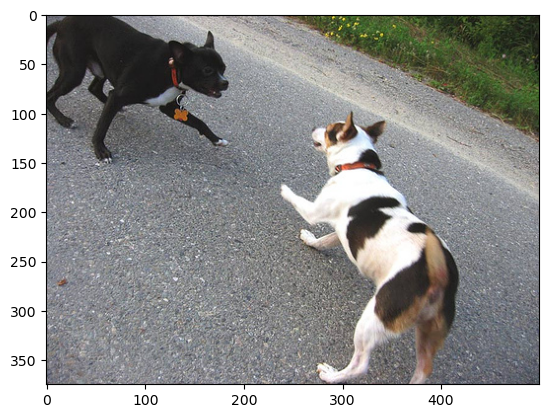

In [33]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
girl in red sweatshirt is laying on the side of the purple flowers


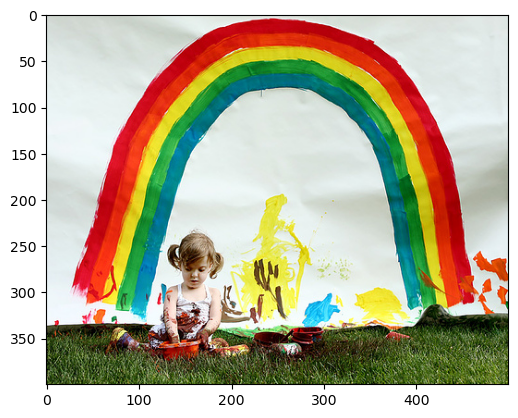

In [34]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
man in black pants and backpack stands next to framed pictures in the snow


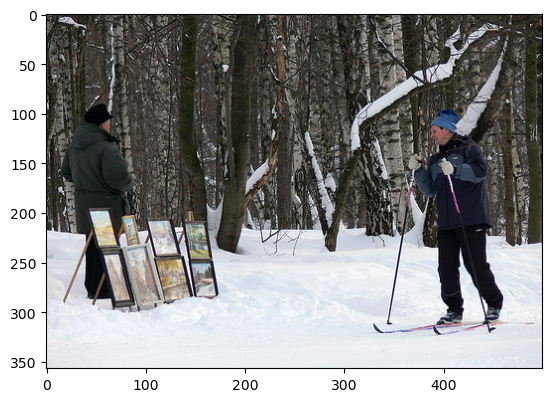

In [35]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq two woman wearing skirts walking down the street together endseq
startseq two women in skirts walking across street endseq
startseq two women ion skirts walk across parking lot endseq
startseq "two women wearing skirts and carrying purses cross street in urban area ." endseq
startseq two women with purses walk in an urban location endseq
--------------------Predicted--------------------
man in red shirt and earmuffs


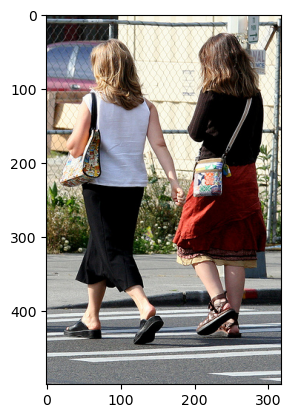

In [36]:
generate_caption('537359971_6e28f5e66e.jpg')

In [37]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

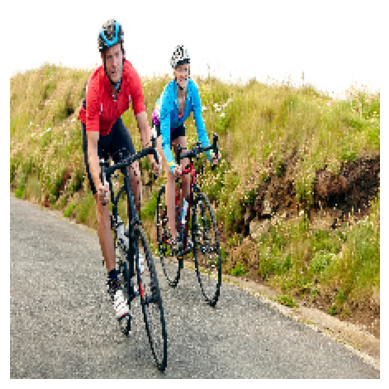

'cyclist is riding bicycle on dirt course course'

In [40]:
image_path = 'cycling.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)



# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

#copy of original image
original_image = np.copy(image)

# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
#display the image
# Display the image
plt.imshow(np.uint8(original_image[0]))
plt.axis('off')  # Turn off axis labels
plt.show()

# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)